## Prepping features dataset


Things to look at:
1. We are currently dropping NA in Demand, Temp. and Humidity. --> Temp and humidity is given each 5 minutes, fill up temp. and humidity with average. 
2. Normalization
3. Demand values we have:
12/31/2018  21:15:00  upandincluding 10/11/2021/ 6:07:00
4. Predicting the demand from 
10/11/2021/ 6:08 upandincluding 12/13/2021  17:59:00 

In [1]:
import math, datetime, time, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import itertools
import tqdm

def load_data(data_path):
  data = pd.read_csv(data_path)  
  return data

inbound = load_data("inbound_loads.csv")
outbound = load_data("outbound_laods.csv")
weather = load_data("weather.csv")
#For loop to ensure that all pallet data is in the same dataframe
pallet = load_data("Pallet_history_Gold_Spike[0].csv")
for x in range(1, 10):
    pallet = pd.concat([pallet, load_data(f"Pallet_history_Gold_Spike[{x}].csv")])
trainentest = load_data("demand_kWtrain_val.csv")
train = trainentest.iloc[:273988,:]
test = trainentest.iloc[273988:, :]

pallet = pallet.drop(['lot_code', 
                      'tran_type', 
                      'final_pallet_code', 
                      'warehouse_facility_id',
                      'source_system_id'], axis=1)

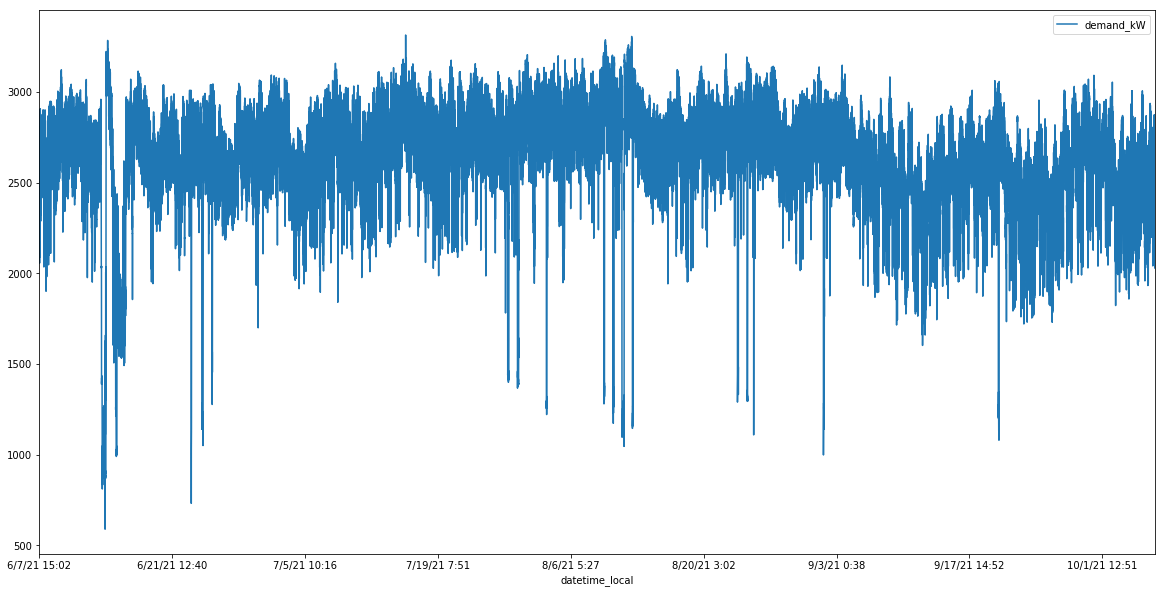

In [33]:

trainentest[100000:268000].plot('datetime_local', 'demand_kW', figsize = (20,10))


###month cycli
###week cycli
###day cycli in afterafternoon its highest, around morning it is lowest


In [15]:
def addtimecol(df, colname): ####input df and colname 
    df[colname] = pd.to_datetime(df[colname])         
    df['year'] = df[colname].dt.year
    df['month'] = df[colname].dt.month
    df['weekday'] = df[colname].dt.weekday
    df['day'] = df[colname].dt.day
    df['hour'] = df[colname].dt.hour
    df['minute'] = df[colname].dt.minute        
    return df
def weekend(x):
    if x['weekday'] > 4:
        return True
    return False
    

Incoming weight feature preprocessing

In [16]:
###Incoming weight feature preprocessing
#load all data
incoming_weight_1h = load_data('incoming_weight_df_1h.csv')
incoming_weight_5h = load_data('incoming_weight_df_5h.csv')
incoming_weight_10h = load_data('incoming_weight_df_10h.csv')
incoming_weight_23h = load_data('incoming_weight_df.csv')
#rename columns 
incoming_weight_5h = incoming_weight_5h.rename(columns = {'weight_23h' : 'weight_5h'})
incoming_weight_1h = incoming_weight_1h.rename(columns = {'weight_23h' : 'weight_1h'})
incoming_weight_10h = incoming_weight_10h.rename(columns = {'weight_23h' : 'weight_10h'})
#get them to a datetime object
incoming_weight_1h['datetime_local'] = pd.to_datetime(incoming_weight_1h['datetime_local'])
incoming_weight_5h['datetime_local'] = pd.to_datetime(incoming_weight_5h['datetime_local'])
incoming_weight_10h['datetime_local'] = pd.to_datetime(incoming_weight_10h['datetime_local'])
incoming_weight_23h['datetime_local'] = pd.to_datetime(incoming_weight_23h['datetime_local'])
#set index to be datetime
incoming_weight_1h.set_index('datetime_local', inplace=True)
incoming_weight_5h.set_index('datetime_local', inplace=True)
incoming_weight_10h.set_index('datetime_local', inplace=True)
incoming_weight_23h.set_index('datetime_local', inplace=True)
#reshape them to start at 2018-31-12 9:15PM
incoming_weight_1h = incoming_weight_1h[2361:]
incoming_weight_5h = incoming_weight_5h[2330:] 
incoming_weight_10h = incoming_weight_10h[2326:]
incoming_weight_23h = incoming_weight_23h[2323:]
#Drop duplicates
incoming_weight_1h = incoming_weight_1h.loc[~incoming_weight_1h.index.duplicated()]
incoming_weight_5h = incoming_weight_5h.loc[~incoming_weight_5h.index.duplicated()]
incoming_weight_10h = incoming_weight_10h.loc[~incoming_weight_10h.index.duplicated()]
incoming_weight_23h = incoming_weight_23h.loc[~incoming_weight_23h.index.duplicated()]


Prepare the pallet movement feature

In [17]:
#load data
pallet_move_5min = load_data('pallet_movement_5min_ft.csv')
#rename column
pallet_move_5min.rename(columns = {'quantity' : 'pallet_movement_5min'}, inplace = True)
#make index a datetime object and set as index
pallet_move_5min['datetime_local'] = pd.to_datetime(pallet_move_5min['datetime_local'])
pallet_move_5min.set_index('datetime_local', inplace = True)
#delete duplicates
pallet_move_5min = pallet_move_5min.loc[~pallet_move_5min.index.duplicated()]

Do the same for doors

In [18]:
base_door = load_data("feature_inbound_outbound_door_open.csv")
base_door = base_door.rename(columns = {'total' : 'doors_open'})
base_door['datetime_local'] = pd.to_datetime(base_door['datetime_local'])
base_door.set_index('datetime_local', inplace=True)

In [19]:
#Create new dummy dfs
base_df = train.copy()
base_weather = weather.copy()

#Remove unnecessary columns
base_df = base_df.drop('Unnamed: 0', axis=1)
base_weather = base_weather.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
base_weather["localstrptime"]= pd.to_datetime(base_weather["localstrptime"])
base_df['datetime_local'] = pd.to_datetime(base_df['datetime_local'])
base_weather = base_weather.rename(columns={'localstrptime':'datetime_local'})
#base_weather['datetime_local'] = [datetime.datetime.strptime(x, 'yyyy/MM/dd HH:mm:SS') for x in base_weather['localstrptime']]

#Add pallet movements feature
##

#Add time columns.
addtimecol(base_df, 'datetime_local')

#Set index to datetime
base_df.set_index('datetime_local', inplace=True)
base_weather.set_index('datetime_local', inplace=True)

#Concatenate the weather DataFrame to the base DataFrame 
base_df = pd.concat([base_df, base_weather], axis=1)

#Concatenate the incoming weight dataframe with the base dataframe
base_df = pd.concat([base_df, incoming_weight_1h], axis=1)
base_df = pd.concat([base_df, incoming_weight_5h], axis=1)
base_df = pd.concat([base_df, incoming_weight_10h], axis=1)
base_df = pd.concat([base_df, incoming_weight_23h], axis=1)

#Concatenate the pallet movement feature
base_df = pd.concat([base_df, pallet_move_5min], axis = 1)

# Drop all NaN values\n"
#base_df.dropna(subset=['demand_kW', 'Temperature'])


Dummy drops things that are NA, maybe sth to look at

In [20]:
#dummy_df = base_df.dropna(subset=['demand_kW', 'Temperature', 'Relative Humidity']) 

dummy_df = base_df.copy()
dummy_df = dummy_df.reset_index()
dummy_df = dummy_df.drop(['hour'], axis=1)
dummy_df = dummy_df.drop(['datetime'], axis=1)
dummy_df = dummy_df.drop(['datetime_local'], axis=1)
dummy_df = dummy_df.drop(['datetime_UTC'], axis=1)
dummy_df

dummy_normalized_df = dummy_df.copy()
#Still drop demand_kW NaNs
dummy_normalized_df = dummy_normalized_df.dropna(subset=['demand_kW'], axis=0)

## Dataframe Column preprocessing functions

- Interpolate columns with missing values
- Normalizing columns (Min-max Normalization)
- One-hot encoding categorical columns

Quite important to do it in that order.

In [21]:
def normalize_column(df, columnname):
    """Function which returns a Dataframe where the given column is normalized through min-max normalization."""
    df[f'{columnname}_normalized'] = (df[columnname] - df[columnname].min()) / (df[columnname].max() - df[columnname].min())
    return df.drop([columnname], axis=1)

def add_one_hot_encoder(df, colname):
    """
    Function which returns a DataFrame where the given column has been removed and replaced by
    one-hot-encoding columns for each value in the original column.
    """
    onehot = pd.get_dummies(df[colname], prefix=colname)
    return df.drop(colname, axis=1).join(onehot)

def interpolate_column(df, colname):
    df[f'{colname}_interpolated'] = df[colname].interpolate(method='linear')
    return df.drop([colname], axis=1)

In [22]:
interpolate = ['Temperature', 'Relative Humidity']
to_normalize = ['Relative Humidity_interpolated', 'Temperature_interpolated', 'weight_1h',  
                'weight_5h', 'weight_10h', 'weight_23h', 'pallet_movement_5min']
add_one_hot_encoding = ['weekday', 'year', 'month']


for x in interpolate:
    dummy_normalized_df = interpolate_column(dummy_normalized_df, x)
for x in to_normalize:
    dummy_normalized_df = normalize_column(dummy_normalized_df, x)
for x in add_one_hot_encoding:
    dummy_normalized_df = add_one_hot_encoder(dummy_normalized_df, x)

#### NOTE: for testing i filled in the missing values with 0, but this is sth to look at

In [36]:
dummy_nonnan = dummy_normalized_df.fillna(value = 0)

# Model Building
- 1 divide into train/test 
- 2 set target column
- 3 get accuracy

https://stats.stackexchange.com/questions/139042/ensemble-of-different-kinds-of-regressors-using-scikit-learn-or-any-other-pytho
Id like to try this, an ensemble of multiple models



# 1. Train and Testset
Things to look at:
1. how to divide test/train/holdout set

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
def test_model(model, data, debug=False):
    xtrain, ytrain, xtest, ytest = data
    if debug:
        print("Fitting model...")
    model.fit(xtrain, ytrain)
    if debug:
        print('Predicting...')
    acc_train = model.predict(xtrain)
    acc_test = model.predict(xtest)    
    if debug:
        print('Calculating mean absolute error...')
    return mean_absolute_error(list(ytrain), acc_train), mean_absolute_error(list(ytest), acc_test)

In [26]:
#Define train, test sets\n",
train, test = train_test_split(dummy_nonnan, shuffle=True)
X_train = train.copy().drop(['demand_kW'], axis=1)
Y_train = train['demand_kW']
X_test = test.copy().drop(['demand_kW'], axis=1)
Y_test = test['demand_kW']

# 3. Model Selection


In [31]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit

In [54]:
#from sklearn.metrics import PredictionErrorDisplay

## Standard formula


In [41]:
def run_timeseries_model(data, model, n_splits = 5, verbose=False):
    """
    Function which receives a data and a model as input.
    Can also receive the amount of splits you want as input.
    For debugging purposes, set verbose to True.
    
    Outputs a list of:
        - The resulting model
        - The final RMSE
        - A list of the resulting Train RMSEs (per fold)
        - A list of the resulting Test RMSEs (per fold)
    """
    
    ts = TimeSeriesSplit(n_splits=n_splits)
    count = 1
    train_rmses = []
    test_rmses = []
    for train, test in ts.split(data):
        if verbose:
            print(f'Starting fold {count}')
        cv_train, cv_test = data.iloc[train], data.iloc[test]
        y_train = cv_train['demand_kW']
        x_train = cv_train.drop(['demand_kW'], axis=1)
        y_test = cv_test['demand_kW']
        x_test = cv_test.drop(['demand_kW'], axis=1)
        if verbose:
            print("Training model...")
        model.fit(x_train, y_train)
        if verbose:
            print("Predicting...")
        y_pred_test = model.predict(x_test)
        y_pred_train = model.predict(x_train)
        if verbose:
            print("Calculating rmse's...")
        train_rmse = mean_squared_error(y_train, y_pred_train #, squard = false)
        test_rmse = mean_squared_error(y_test, y_pred_test #, squard = false)
        train_rmses.append(train_rmse)
        test_rmses.append(test_rmse)
        if verbose:
            print(f'Fold {count} train error: {train_rmse}. Test error: {test_rmse}.')
        count += 1
    return [model, test_rmse, train_rmses, test_rmses]


In [67]:
test_parameters = {
    'n_estimators': 100,
    'loss': 'huber', 
    'learning_rate': 0.1,
    'max_leaf_nodes': None,
    'max_depth': 9
    }
reg = GradientBoostingRegressor(**test_parameters)
reg.fit(X_train, Y_train)
print(mean_squared_error(y_test, reg.predict(X_test)))
#model_GB_parameterized = GradientBoostingRegressor(**test_parameters)
#run_timeseries_model(dummy_nonnan, model_GB_parameterized, n_splits=2, verbose=True)

NameError: name 'y_test' is not defined

# Model Testing 

model decision
N is big, we have many datapoints



Overfitting/underfitting, you want training set to be too small to overfit


#### Random Forest

In [16]:
parameter_settings_RF = {
    'n_estimators': [10, 20, 50],
    'criterion': ['squared_error', 'friedman_mse', 'poisson']#,
    #'max_depth': [2, 4, 6],
    #'min_samples_split': [2, 4, 8]
}
data = [X_train, Y_train, X_test, Y_test]
model_RF = RandomForestRegressor
#test_RF = model_optimizer(data, RandomForestRegressor_RF, parameter_settings_RF)

In [15]:
def model_optimizer(data, model, params):
    parameter_combinations = itertools.product(*params.values())
    results = {}
    for parameters in parameter_combinations:
        start = time.time()
        params_dict = dict(zip(params.keys(), parameters))
        print('Testing model with parameters: ' + str(params_dict))
        current_model = model(**params_dict)
        mae_train, mae_test = test_model(current_model, data, debug = False)
        print(f'Mean Absolute Error Train = {mae_train}')
        print(f'Mean Absolute Error Test = {mae_test}')
        modelname = str(params_dict)
        end = time.time()
        print(f'Time spent: {end-start} seconds. \n')
        results[modelname] = [mae_train, mae_test, (end-start), model]
    return results

#### Gradient Boosting

Theory says: start with high n_estimators (between 100 and 500) and high max_leaf_nodes (between 2 and 8) and adjust learning_rate

Higher n_estimators works better, but more time expensive, 500 trees takes like 3 minutes to fit
Lower learning rate makes worse, but after 600, the n_estimators gain is not that much anymore.

max_leaf_nodes makes better, but 

max_leaf_nodes x learning rate: 
for small n_estimators; small learning rate, is smaller effect of more leaf_nodes 
for big n_estimators; small learning rate, is smaller effect of more leaf_nodes

max_leaf_nodes x n_estimators
Bigger positive effect of max_leaf_nodes when n_estimators is increased

learning rate x n_estimators
Learning rate makes a lot of the difference. 
The effect of learning rate becomes bigger as n_estimators increases. We jump from 0.1, 0.005, 0.001. The learning rate delta that gains the most positive effect becomes a smaller learning rate as n_estimators increases, which means that into the extreme, the effect of more n_estimators with learning rate 0.1 becomes nothing and then learning rate 0.005 will outperform maybe. 
Does this mean that learning rate of 0.05/0.01 will do better? 

Best combination is 
accuracy is 148: n_estimators = 500, learning rate = 0.1, max_leaf_nodes = 7. 
accuracy is 146: n_estimators = 600, learning rate = 0.05, max_leaf_nodes = 11. 
accurcay is 144: n_estimators = 700, learning rate = 0.05, max_leaf_nodes = 11. 

accuracy is 134: n_estimators = 600, learning rate = 0.1, max_leaf_nodes = 11

accuracy is 93: n_estimators = 800, learning_rate: 0.1, max_leaf_nodes : None, max_depth: 8

accuracy is 78: n_estimators = 800, learning_rate: 0.1, max_leaf_nodes : None, max_depth: 11

optimizing parameters:
n_estimators: [50, 100, 200, 300, 400, 500], ##higher number creates more accuracy but 1000 is too much because it takes like 60000 seconds to finish the algorithm
loss: ['huber'], 
learning_rate: [0.1, 0.005, 0.001], ##lower learning rate makes worse fitting, no of max_leaf_nodes and n_estimators this effect
max_leaf_nodes: [3, 5, 7],
max_depth: [None]



In [53]:
parameter_settings_GB =    {
    
    'n_estimators': [800],
    'loss': ['huber'], 
    'learning_rate': [0.1],
    'max_leaf_nodes': [None],
    'max_depth': [9, 10, 11]
}

test_GB = model_optimizer(data, model_GB, parameter_settings_GB)

Testing model with parameters: {'n_estimators': 800, 'loss': 'huber', 'learning_rate': 0.1, 'max_leaf_nodes': None, 'max_depth': 9}
Fitting model...
Predicting...
Calculating mean absolute error...
Mean Absolute Error = 87.96448814213798
Time spent: 1660.5536830425262 seconds. 

Testing model with parameters: {'n_estimators': 800, 'loss': 'huber', 'learning_rate': 0.1, 'max_leaf_nodes': None, 'max_depth': 10}
Fitting model...
Predicting...
Calculating mean absolute error...
Mean Absolute Error = 82.10611772035071
Time spent: 2387.6310358047485 seconds. 

Testing model with parameters: {'n_estimators': 800, 'loss': 'huber', 'learning_rate': 0.1, 'max_leaf_nodes': None, 'max_depth': 11}
Fitting model...
Predicting...
Calculating mean absolute error...
Mean Absolute Error = 78.20263129670134
Time spent: 3316.168856859207 seconds. 



In [52]:
parameter_settings_good_GB =    {
    
    'n_estimators': [800, 1000],
    'loss': ['huber'], 
    'learning_rate': [0.1],
    'max_leaf_nodes': [None],
    'max_depth': [6, 7,8]
}

test_GB = model_optimizer(data, model_GB, parameter_settings_good_GB)


Testing model with parameters: {'n_estimators': 800, 'loss': 'huber', 'learning_rate': 0.1, 'max_leaf_nodes': None, 'max_depth': 6}
Fitting model...
Predicting...
Calculating mean absolute error...
Mean Absolute Error = 108.9528538029399
Time spent: 557.44975233078 seconds. 

Testing model with parameters: {'n_estimators': 800, 'loss': 'huber', 'learning_rate': 0.1, 'max_leaf_nodes': None, 'max_depth': 7}
Fitting model...
Predicting...
Calculating mean absolute error...
Mean Absolute Error = 100.02792464181051
Time spent: 814.4752669334412 seconds. 

Testing model with parameters: {'n_estimators': 800, 'loss': 'huber', 'learning_rate': 0.1, 'max_leaf_nodes': None, 'max_depth': 8}
Fitting model...
Predicting...
Calculating mean absolute error...
Mean Absolute Error = 93.3609256345042
Time spent: 1165.155204296112 seconds. 

Testing model with parameters: {'n_estimators': 1000, 'loss': 'huber', 'learning_rate': 0.1, 'max_leaf_nodes': None, 'max_depth': 6}
Fitting model...
Predicting...
C

KeyboardInterrupt: 

In [38]:
parameter_settings_GB = {
    'n_estimators': [600, 800, 1000],
    'loss': ['huber'], 
    'learning_rate': [0.1],
    'max_leaf_nodes': [5, 8, 11],
    'max_depth': [None]
    
}
data = [X_train, Y_train, X_test, Y_test]
model_GB = GradientBoostingRegressor


In [46]:
test_GB = model_optimizer(data, model_GB, parameter_settings_GB)

Testing model with parameters: {'n_estimators': 600, 'loss': 'huber', 'learning_rate': 0.1, 'max_leaf_nodes': 5, 'max_depth': None}


KeyboardInterrupt: 

In [37]:
test_GB = model_optimizer(data, model_GB, parameter_settings_GB)
   # 'n_estimators': [600, 700, 800],
   # 'loss': ['huber'], 
   # 'learning_rate': [0.05, 0.01, 0.005],
   # 'max_leaf_nodes': [5, 8, 11],
   # 'max_depth': [None]
    

Testing model with parameters: {'n_estimators': 600, 'loss': 'huber', 'learning_rate': 0.05, 'max_leaf_nodes': 5, 'max_depth': None}
Mean Absolute Error = 164.515986308457
Time spent: 156.9882915019989 seconds. 

Testing model with parameters: {'n_estimators': 600, 'loss': 'huber', 'learning_rate': 0.05, 'max_leaf_nodes': 8, 'max_depth': None}
Mean Absolute Error = 154.93049807096298
Time spent: 200.88396453857422 seconds. 

Testing model with parameters: {'n_estimators': 600, 'loss': 'huber', 'learning_rate': 0.05, 'max_leaf_nodes': 11, 'max_depth': None}
Mean Absolute Error = 146.7717758665629
Time spent: 235.93361020088196 seconds. 

Testing model with parameters: {'n_estimators': 600, 'loss': 'huber', 'learning_rate': 0.01, 'max_leaf_nodes': 5, 'max_depth': None}
Mean Absolute Error = 183.49976713939282
Time spent: 186.70279741287231 seconds. 

Testing model with parameters: {'n_estimators': 600, 'loss': 'huber', 'learning_rate': 0.01, 'max_leaf_nodes': 8, 'max_depth': None}
Mean A

KeyboardInterrupt: 

In [33]:
test_GB = model_optimizer(data, model_GB, parameter_settings_GB)
    #'n_estimators': [50, 100, 200, 300, 400, 500],
    #'loss': ['huber'], 
    #'learning_rate': [0.05, 0.01], 
    #'max_leaf_nodes': [5, 7, 9],
    #'max_depth': [None]

Testing model with parameters: {'n_estimators': 50, 'loss': 'huber', 'learning_rate': 0.05, 'max_leaf_nodes': 5, 'max_depth': None}
Mean Absolute Error = 201.08590126976355
Time spent: 16.689571142196655 seconds. 

Testing model with parameters: {'n_estimators': 50, 'loss': 'huber', 'learning_rate': 0.05, 'max_leaf_nodes': 7, 'max_depth': None}
Mean Absolute Error = 193.90655031802763
Time spent: 21.015475273132324 seconds. 

Testing model with parameters: {'n_estimators': 50, 'loss': 'huber', 'learning_rate': 0.05, 'max_leaf_nodes': 9, 'max_depth': None}
Mean Absolute Error = 190.34137763258644
Time spent: 23.714487075805664 seconds. 

Testing model with parameters: {'n_estimators': 50, 'loss': 'huber', 'learning_rate': 0.01, 'max_leaf_nodes': 5, 'max_depth': None}
Mean Absolute Error = 274.8777890680345
Time spent: 16.937408685684204 seconds. 

Testing model with parameters: {'n_estimators': 50, 'loss': 'huber', 'learning_rate': 0.01, 'max_leaf_nodes': 7, 'max_depth': None}
Mean Abso

In [30]:
test_GB = model_optimizer(data, model_GB, parameter_settings_GB)
#parameter_settings_GB = {
#    'n_estimators': [50, 100, 200, 300, 400, 500],
#    'loss': ['huber'], 
#    'learning_rate': [0.1, 0.005, 0.001], 
#    'max_leaf_nodes': [3, 5, 7],
#    'max_depth': [None]

Testing model with parameters: {'n_estimators': 50, 'loss': 'huber', 'learning_rate': 0.1, 'max_leaf_nodes': 3, 'max_depth': None}
Mean Absolute Error = 196.39137159334896
Time spent: 12.062238931655884 seconds. 

Testing model with parameters: {'n_estimators': 50, 'loss': 'huber', 'learning_rate': 0.1, 'max_leaf_nodes': 5, 'max_depth': None}
Mean Absolute Error = 186.03185673019624
Time spent: 16.537100076675415 seconds. 

Testing model with parameters: {'n_estimators': 50, 'loss': 'huber', 'learning_rate': 0.1, 'max_leaf_nodes': 7, 'max_depth': None}
Mean Absolute Error = 179.78136016489964
Time spent: 20.999524354934692 seconds. 

Testing model with parameters: {'n_estimators': 50, 'loss': 'huber', 'learning_rate': 0.005, 'max_leaf_nodes': 3, 'max_depth': None}
Mean Absolute Error = 307.0366772010188
Time spent: 12.264090061187744 seconds. 

Testing model with parameters: {'n_estimators': 50, 'loss': 'huber', 'learning_rate': 0.005, 'max_leaf_nodes': 5, 'max_depth': None}
Mean Absol

Evaluating Gradient Boosting
feature importance --> 
Generalizing out of distribution --> cross validation
evaluation metric --> Mean Absolute Error




In [ ]:
current_model_GB = GradientBoostingRegressor()


In [63]:
parameter_settings_good_GB =    {
    
    'n_estimators': [800],
    'loss': ['huber'], 
    'learning_rate': [0.1],
    'max_leaf_nodes': [None],
    'max_depth': [11]
}
current_model_GB = GradientBoostingRegressor
Results_GB = model_optimizer(data, current_model_GB, parameter_settings_good_GB)

#current_model_GB = current_model_GB(parameter_settings_good_GB)


Testing model with parameters: {'n_estimators': 800, 'loss': 'huber', 'learning_rate': 0.1, 'max_leaf_nodes': None, 'max_depth': 11}
Mean Absolute Error = (39.90902236065767, 78.92930092945761)
Time spent: 4430.567314863205 seconds. 



In [64]:
Results_GB.feature_importances_

{"{'n_estimators': 800, 'loss': 'huber', 'learning_rate': 0.1, 'max_leaf_nodes': None, 'max_depth': 11}": [(39.90902236065767,
   78.92930092945761),
  4430.567314863205]}

## Visualizing sample set (X and Y) ~ D
I want to describe the Hypothesis space/Sample space (training set and the sample Distribution) to theorize about: 

1. Is it probable that the generalization error is similar to the empirical error?
2. What size must the number of training samples be given the amount of parameters/features we are trying to learn given the error rate/probability we chose. 

#### Describe Sample Space
The training samples we use is X_train, it is the features. We assume that all datapoints are drawn iid from distribution D. 

#### Describe Hypothesis Space
The hypothesis space is all the possible configurations your A can choose from. We try to find the best h to describe the relation between features xi and labels yi. It says that the probability that the space contains a training-consistent hypothesis with a true error rate > epsilon is lower than |H|e^{-epsilon m}.  

For decision trees, the hypothesis space is the set of possible decision trees.

#### Requirements to use PAC learning 
1. iid drawn examples
2. The Consistent Distribution Assumption: there is one probability distribution D that governs both training and testing examples.

#### Proof that a hypothesis space contains a good hypothesis, learnable with A
We want to find the probability of H containing a hypothesis with zero error on the training set and the true error rate greater than epsilon.

#### Proof that training set size m is big enough

As accuracy parameter \epsilon we pick 90% which is 0.1. With confidence parameter we pick 95% which is \delta = 0.05
We have m = 200000, so how big can our hypothesis space be?

function to calc. this can be found here:https://www.cis.upenn.edu/~danroth/Teaching/CS446-17/LectureNotesNew/colt/main.pdf on page 9. 

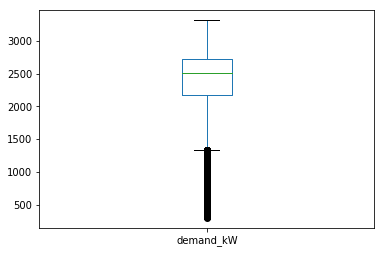

In [75]:
Y_train.plot.box()

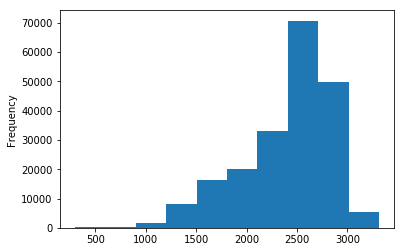

In [92]:
Y_train.plot.hist()


In [99]:
Y_train.std()

450.37126325223613

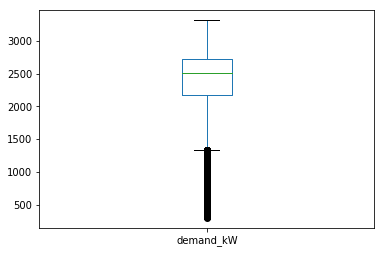

In [102]:
Y_train.plot.box()

In [104]:
from sklearn.model_selection import TimeSeriesSplit
import time

def run_timeseries_model(data, model, n_splits = 5, verbose=False):
    """
    Function which receives a data and a model as input.
    Can also receive the amount of splits you want as input.
    For debugging purposes, set verbose to True.
    
    Outputs a list of:
        - The resulting model
        - The final RMSE
        - A list of the resulting Train RMSEs (per fold)
        - A list of the resulting Test RMSEs (per fold)
    """
    
    ts = TimeSeriesSplit(n_splits=n_splits)
    count = 1
    train_rmses = []
    test_rmses = []
    for train, test in ts.split(data):
        if verbose:
            print(f'Starting fold {count}')
        cv_train, cv_test = data.iloc[train], data.iloc[test]
        y_train = cv_train['demand_kW']
        x_train = cv_train.drop(['demand_kW'], axis=1)
        y_test = cv_test['demand_kW']
        x_test = cv_test.drop(['demand_kW'], axis=1)
        train_start = time.time()
        if verbose:
            print("Training model...")
        model.fit(x_train, y_train)
        train_stop = time.time()
        
        predict_start = time.time()
        if verbose:
            print("Predicting...")
        y_pred_test = model.predict(x_test)
        y_pred_train = model.predict(x_train)
        predict_stop = time.time()
        
        rmse_start = time.time()
        if verbose:
            print("Calculating rmse's...")
        train_rmse = mean_squared_error(y_train, y_pred_train)#, squared=False)
        test_rmse = mean_squared_error(y_test, y_pred_test)#, squared=False)
        rmse_stop = time.time()
        
        train_rmses.append(train_rmse)
        test_rmses.append(test_rmse)
        timings = [(train_stop - train_start), (predict_stop - predict_start), (rmse_stop - rmse_start), (rmse_stop - train_start)]
        if verbose:
            print(f'Fold {count} train error: {train_rmse}. Test error: {test_rmse}. Time taken: {timings[3]} s.')
        count += 1
    all_rmses = [train_rmses, test_rmses]
    return [model, test_rmse, all_rmses, timings]

In [90]:
import itertools
import pickle

def find_optimal_parameters(data, model, params, n_splits=5, verbose=False):
    """
    Function which will find the optimal parameters within set boudaries.
    Receives as input:
    - The data
    - A model
    - The dictionary of parameters to optimize:
        - Key: parameter name
        - Value: List of testing parameter values.
    - The amount of Timeseries splits for crossvalidation (Standard: 5)
    - Whether information should be printed or not (Standard: False)
    """
    
    parameter_combinations = itertools.product(*params.values())
    results = {}
    count = 1
    for x in parameter_combinations:
        model_name = f'Model {count}'
        results[model_name] = [dict(zip(params.keys(), x))]
        count +=1
    lowest = 1000000000
    best_model = ""
    print(results['Model 1'])
    for model_name in results.keys():
        params_dict = results[model_name][0]
        print(f'Testing model {model_name} with parameters: {params_dict}')
        current_model = model(**params_dict)
        results[model_name].append(run_timeseries_model(data, current_model, n_splits=n_splits, verbose=verbose))
        print(results[model_name])
        print(f'Finished testing model. Test RMSE: {results[model_name][1][1]}. Time taken: {results[model_name][1][3][3]}.')
        if results[model_name][1][1] < lowest:
            lowest = results[model_name][1][1]
            best_model = model_name
    print(f"Optimization completed. Best model is {best_model} with parameters {results[model_name]}. \n RMSE is {results[model_name][1][1]}.")
    pickle.dump(best_model, open("Best_model.pkl", 'wb'))
    return results

In [114]:
model_GB = GradientBoostingRegressor()
parameter_settings_good_GB =    {
    
    'n_estimators': [400, 600, 800],
    'loss': [None], 
    'learning_rate': [0.1, 0.05, 0.01],
    'max_leaf_nodes': [None],
    'max_depth': [4, 6, 8]
}
parameter_settings_quick_GB =    {
    
    'n_estimators': [600],   
    'loss' : ['huber'],
    'learning_rate': [0.1, 0.3],
    'max_leaf_nodes': [None],
    'max_depth': [4, 8]
}

parameter_settings_qiuck_RF ={
    
    'n_estimators': [100]   
}

In [108]:
find_optimal_parameters(dummy_nonnan, GradientBoostingRegressor, parameter_settings_quick_GB, n_splits=2, verbose=True)

[{'n_estimators': 600, 'learning_rate': 0.1, 'max_leaf_nodes': None, 'max_depth': 4}]
Testing model Model 1 with parameters: {'n_estimators': 600, 'learning_rate': 0.1, 'max_leaf_nodes': None, 'max_depth': 4}
Starting fold 1
Training model...
Predicting...
Calculating rmse's...
Fold 1 train error: 24727.1849380477. Test error: 222292.11077577685. Time taken: 52.734848737716675 s.
Starting fold 2
Training model...
Predicting...
Calculating rmse's...
Fold 2 train error: 30382.32924607632. Test error: 99236.54968253695. Time taken: 109.48254251480103 s.
[{'n_estimators': 600, 'learning_rate': 0.1, 'max_leaf_nodes': None, 'max_depth': 4}, [GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimator

{'Model 1': [{'n_estimators': 600,
   'learning_rate': 0.1,
   'max_leaf_nodes': None,
   'max_depth': 4},
  [GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                learning_rate=0.1, loss='ls', max_depth=4, max_features=None,
                max_leaf_nodes=None, min_impurity_decrease=0.0,
                min_impurity_split=None, min_samples_leaf=1,
                min_samples_split=2, min_weight_fraction_leaf=0.0,
                n_estimators=600, n_iter_no_change=None, presort='auto',
                random_state=None, subsample=1.0, tol=0.0001,
                validation_fraction=0.1, verbose=0, warm_start=False),
   99236.54968253695,
   [[24727.1849380477, 30382.32924607632],
    [222292.11077577685, 99236.54968253695]],
   [107.0177812576294,
    2.458468437194824,
    0.006292819976806641,
    109.48254251480103]]],
 'Model 2': [{'n_estimators': 600,
   'learning_rate': 0.1,
   'max_leaf_nodes': None,
   'max_depth': 8},
  [GradientBoostingRegr

In [118]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES

In [121]:
model = HWES(X_train, trend='add', seasonal='mul')

C:\Users\sonja\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [122]:
tes_model = HWES(X_train,
                                 trend="add",
                                 seasonal="add",
                                 seasonal_periods=12).fit(smoothing_level=0.5,
                                                          smoothing_slope=0.5,
                                                          smoothing_seasonal=0.5)

y_pred = tes_model.forecast(48)
plot_co2(X_train, X_test, y_pred, "Triple Exponential Smoothing")

C:\Users\sonja\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


NotImplementedError: Only 1 dimensional data supported

In [ ]:
run_timeseries_model